In [1]:
import numpy as np
import faiss
from openai import AzureOpenAI
import re
from IPython.display import Image as IpyImage, display
import re
import os
import base64
import io
from PIL import Image


In [17]:

def query_vector_index(index, query_embedding, k=5):
    """Query the FAISS index to find the k most similar items."""
    # Search the index
    distances, indices = index.search(np.array([query_embedding]).astype('float32'), k)
    return indices[0]

def construct_prompt(retrieved_texts, question):
    """Build a prompt to pass to the GPT-4 model."""

    context = "\n\n".join(retrieved_texts)
    return {
        "role": "system",
        "content": f"There are image placeholders in the context like: '[Image: page_x_img_y.png]'. Ensure that you reference these image placeholders as frequently as appropriate in your response, integrating them coherently with the textual content.\n\nContext:\n{context}\n\nQuestion: {question}"

    }

def construct_image_prompt(retrieved_texts):
    """Search for image placeholders, process images, and return an array of image objects."""
    file_path = 'images'
    image_objects = []
    image_regex = r'\[Image: (.+?)\]'

    for text in retrieved_texts:
        matches = re.findall(image_regex, text)

        for file_name in matches:
            full_name = os.path.join(file_path, file_name)
            if os.path.exists(full_name):
                # Open the image file, resize it, and convert to base64
                with Image.open(full_name) as img:
                    # Resize the image to 224x224
                    img_resized = img.resize((224, 224))
                    
                    # Convert image to JPEG and encode to base64
                    buffered = io.BytesIO()
                    img_resized.save(buffered, format="JPEG")
                    encoded_image = base64.b64encode(buffered.getvalue()).decode('utf-8')
                    
                    # Create image object
                    image_object = {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": f"[image: {file_name}]"},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{encoded_image}"
                                },
                            },
                        ]
                    }
                    image_objects.append(image_object)
            else:
                print(f"Warning: Image file {file_name} not found.")
    
    return image_objects


def query_openai(messages, client):
    """Query the Azure OpenAI GPT-4 model with a constructed prompt."""
    response = client.chat.completions.create(
        model="AA-gpt4-o",
        messages=messages,
        stream=False,
        max_tokens=512,  # Adjust depending on desired length and model limits
        temperature=0,  # Adjust depending on desired creativity
        top_p=0,
        seed=42

    )
    return response.choices[0].message.content.strip()

# Initialize Azure OpenAI client
client = AzureOpenAI(
    azure_endpoint="https://msec-cognitive-sb-eval02-oai.openai.azure.com", 
    api_key="d3116cc2cd9c47fda7474f67aa272385",  
    api_version="2024-02-01",
    timeout=300
)

# Load the FAISS index
index = faiss.read_index('faiss_index.index')

# Assume you have a dictionary of documents
with open('output_processed.txt', 'r') as file:
    # read the contents of the file
    contents = file.read()
    # print the contents to the screen
    
documents = [x.strip() for x in contents.split('--- Page Break ---')]


client = AzureOpenAI(
  azure_endpoint = "https://msec-cognitive-sb-eval02-oai.openai.azure.com", 
  api_key="d3116cc2cd9c47fda7474f67aa272385",  
  api_version="2024-02-01",
  timeout=300
)

def multi_rag_pipeline(question):
    # Convert the question into an embedding
    # For now, you can use a simple embedding model; here, it's assumed as a dummy embedding
    response = client.embeddings.create(model="AA-text-embedding-3-large", input=question)

    question_embedding = response.data[0].embedding

    # Query the vector index
    relevant_indices = query_vector_index(index, question_embedding)

    # Retrieve relevant documents
    retrieved_texts = [documents[i] for i in relevant_indices]
    print('Retrived Texts:', retrieved_texts)
    # Construct prompt for GPT-4
    # Construct message for GPT-4
    system_message = construct_prompt(retrieved_texts, question)
    system_image_messages = construct_image_prompt(retrieved_texts)
    print('System Image Messages:', system_image_messages)
    user_message = {"role": "user", "content": question}
    messages = [system_message, *system_image_messages, user_message]

    # Query GPT-4
    response = query_openai(messages, client)

    return response


In [18]:


def resize_image(image_path, max_size=(400, 400)):
    with Image.open(image_path) as img:
        img.thumbnail(max_size)
        buf = io.BytesIO()
        img.save(buf, format='PNG')
        return buf.getvalue()

def display_text_and_images(text, image_folder="./images", max_size=(400, 400)):
    # Find all image placeholders
    placeholders = re.findall(r'\[Image: (.+?)\]', text)
    
    # Split the text at image placeholders
    parts = re.split(r'\[Image: .+?\]', text)
    
    # Process each part and display each associated image
    for i, part in enumerate(parts):
        # Print the text part
        if part.strip():
            print(part.strip())
        
        # If there's an image placeholder, display the image
        if i < len(placeholders):
            image_path = os.path.join(image_folder, placeholders[i])
            if os.path.exists(image_path):
                try:
                    # Display image in Jupyter Notebook
                    print(f"Image: {placeholders[i]}")
                    img_data = resize_image(image_path, max_size)
                    display(IpyImage(data=img_data))
                except Exception as e:
                    print(f"Error displaying image {placeholders[i]}: {str(e)}")
            else:
                print(f"Image not found: {placeholders[i]}")

Retrived Texts: ['[Image: page_3_img_1.png] Figure 1: The Transformer - model architecture. The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of [Image: page_3_img_1.png] Figure 1, respectively. 3.1 Encoder and Decoder Stacks N = 6 The encoder is composed of a stack of identical layers. Each layer has two Encoder: sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position- wise fully connected feed-forward network. We employ a residual connection [11] around each of the two sub-layers, followed by layer normalization [1]. That is, the output of each sub-layer is LayerNorm(x + Sublayer(x) Sublayer(x)), where is the function implemented by the sub-layer itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding = layers, produce outputs of dimension 512. dmodel N = 6 
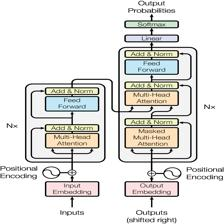
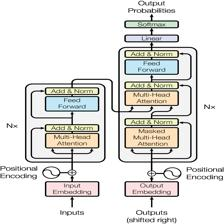
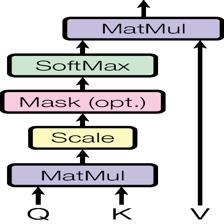
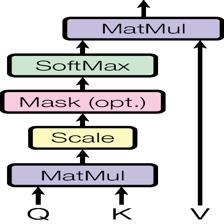
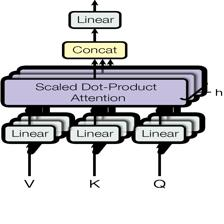
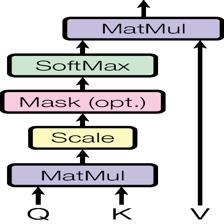
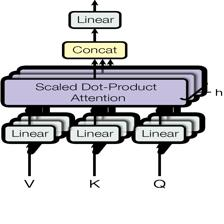
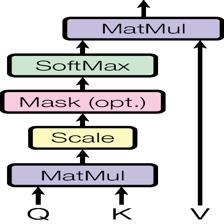

In [19]:

# Example question
question = "What is the self-attention architecture?"

# Run the RAG pipeline
answer = multi_rag_pipeline(question)
print(answer)


The self-attention architecture, as depicted in the images, is a key component of the Transformer model. Here's a breakdown:

1. **Self-Attention Mechanism**:
   - **Scaled Dot-Product Attention** (
Image: page_4_img_1.png


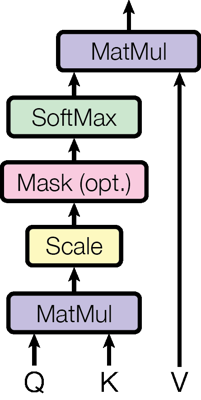

): This involves computing the dot products of the query (Q) with all keys (K), scaling by the square root of the dimension of the keys, applying a softmax function to obtain weights, and then using these weights to compute a weighted sum of the values (V).
   - **Optional Masking**: In the decoder, a mask is applied to prevent attending to future positions.

2. **Multi-Head Attention** (
Image: page_4_img_2.png


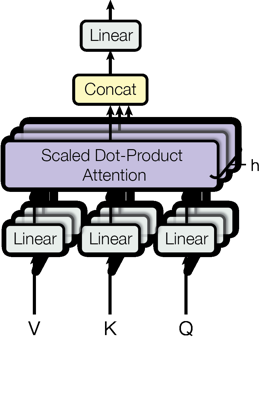

):
   - Instead of a single attention function, multiple attention heads are used. Each head has its own set of learned linear projections for Q, K, and V.
   - The outputs of these attention heads are concatenated and linearly transformed to produce the final output.

3. **Integration in Transformer** (
Image: page_3_img_1.png


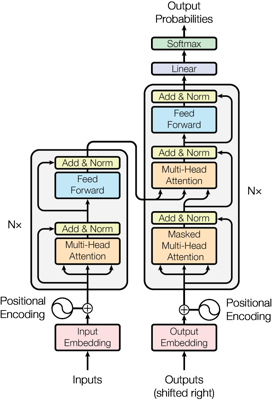

):
   - **Encoder**: Consists of layers with self-attention followed by feed-forward networks. Each layer has residual connections and layer normalization.
   - **Decoder**: Similar to the encoder but includes an additional encoder-decoder attention layer to attend to the encoder's output.

This architecture allows the model to focus on different parts of the input sequence, capturing dependencies regardless of their distance.


In [20]:
# Process and display the text with images
display_text_and_images(answer)